# 1 Data wrangling<a id='1_Data_wrangling'></a>

## 1.1 Introduction<a id='1.1_Introduction'></a>

In this section, we will gather covid data from the official CDC database and initiate data wrangling. Out ultimate goal is to see if the distribution of number of confirmed cases, deaths or recoveries follow the Benford's law.

In [10]:
# import relevant packages
import pandas as pd
import json
import matplotlib.pyplot as plt 
import requests
import numpy as np
import requests
import collections
import random
import math
#from scipy import stats
from scipy.stats.distributions import chi2

In [51]:
# scrap the cdc website
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
us_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/04-03-2021.csv')
url = "https://covid.cdc.gov/covid-data-tracker/COVIDData/getAjaxData"
data = requests.get(url, params={"id": "US_MAP_DATA"}).json()
# create a dataframe object
raw_df = pd.DataFrame(data["US_MAP_DATA"])
#view the 1st 5 rows
#raw_df.head()

## 1.2 Data Exploration

First we are going to audit the data by displaying their summaries

In [13]:
confirmed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Columns: 442 entries, Province/State to 4/3/21
dtypes: float64(2), int64(438), object(2)
memory usage: 946.3+ KB


The data contains 274 rows and more than 440 columns (the number of columns grows daily as the number of confirmed cases are updated daily)

In [14]:
deaths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Columns: 442 entries, Province/State to 4/3/21
dtypes: float64(2), int64(438), object(2)
memory usage: 946.3+ KB


In [15]:
recoveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Columns: 442 entries, Province/State to 4/3/21
dtypes: float64(2), int64(438), object(2)
memory usage: 894.5+ KB


We can see right away that there are fewer rows for recoveries than deaths or confirmed cases, that is some countries did not report their numbers of recoveries

In [52]:
us_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Province_State        58 non-null     object 
 1   Country_Region        58 non-null     object 
 2   Last_Update           58 non-null     object 
 3   Lat                   56 non-null     float64
 4   Long_                 56 non-null     float64
 5   Confirmed             58 non-null     int64  
 6   Deaths                58 non-null     int64  
 7   Recovered             0 non-null      float64
 8   Active                0 non-null      float64
 9   FIPS                  58 non-null     float64
 10  Incident_Rate         56 non-null     float64
 11  Total_Test_Results    56 non-null     float64
 12  People_Hospitalized   0 non-null      float64
 13  Case_Fatality_Ratio   57 non-null     float64
 14  UID                   58 non-null     float64
 15  ISO3                  58 

US data that show state and region data, the data contain some missing information

In [18]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   abbr                               61 non-null     object 
 1   tot_cases                          61 non-null     int64  
 2   tot_cases_last_24_hours            61 non-null     int64  
 3   conf_cases                         61 non-null     int64  
 4   prob_cases                         61 non-null     int64  
 5   new_cases07                        61 non-null     int64  
 6   new_deaths07                       61 non-null     int64  
 7   Seven_day_avg_new_cases_per_100k   61 non-null     float64
 8   Seven_day_avg_new_deaths_per_100k  61 non-null     float64
 9   Seven_day_cum_new_cases_per_100k   61 non-null     float64
 10  Seven_day_cum_new_deaths_per_100k  61 non-null     float64
 11  tot_death                          61 non-null     int64  
 

US data showing cumulatively, cases and weekly averages, some columns also have missing information about confirmed cases, probable cases, confirmed deaths and probable deaths.

In [38]:
raw_df.head()

,abbr,tot_cases,tot_cases_last_24_hours,prob_cases,new_cases07,new_deaths07,Seven_day_avg_new_cases_per_100k,Seven_day_avg_new_deaths_per_100k,Seven_day_cum_new_cases_per_100k,Seven_day_cum_new_deaths_per_100k,tot_death,tot_death_last_24_hours,conf_death,prob_death,death_100k,incidence,id,fips,name
0,AK,60918,0,0,1208,0,23.6,0.0,165.1,0.0,309,0,NaN,NaN,42.0,8327,2,02,Alaska
1,AL,516615,0,114319,2543,112,7.4,0.3,51.9,2.3,10637,0,8389.0,2248.0,216.0,10536,1,01,Alabama
2,AR,330970,0,0,1110,51,5.3,0.2,36.8,1.7,5641,0,NaN,NaN,186.0,10967,5,05,Arkansas
3,AS,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,NaN,NaN,NaN,0,60,60,American Samoa
4,AZ,843838,0,59882,4504,79,8.8,0.2,61.9,1.1,16991,0,15064.0,1927.0,233.0,11593,4,04,Arizona


In [43]:
raw_df['name']

0                       Alaska
1                      Alabama
2                     Arkansas
3               American Samoa
4                      Arizona
                ...           
56                  Washington
57                   Wisconsin
58               West Virginia
59                     Wyoming
60    United States of America
Name: name, Length: 61, dtype: object

The coulmn `name` contains all the `50 states` and 9 more territories of the USA, but New York is subdivided into NYC and Upstate New York. 

In [20]:
#Filter the data to find the row about NY and:
raw_df[raw_df.name == 'New York'].T

,38
abbr,NY
tot_cases,1038858
tot_cases_last_24_hours,0
conf_cases,0
prob_cases,0
new_cases07,28082
new_deaths07,164
Seven_day_avg_new_cases_per_100k,36.3
Seven_day_avg_new_deaths_per_100k,0.2
Seven_day_cum_new_cases_per_100k,254


In [21]:
#Filter the data to find the row about CA and:
raw_df[raw_df.name == 'California'].T

,5
abbr,CA
tot_cases,3577951
tot_cases_last_24_hours,0
conf_cases,0
prob_cases,0
new_cases07,18758
new_deaths07,853
Seven_day_avg_new_cases_per_100k,6.8
Seven_day_avg_new_deaths_per_100k,0.3
Seven_day_cum_new_cases_per_100k,47.5


In [22]:
# Missing values in each column and the percentage
missing = pd.concat([raw_df.isnull().sum(), 100 * raw_df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by=['count', '%'])

,count,%
abbr,0,0.000000
tot_cases,0,0.000000
tot_cases_last_24_hours,0,0.000000
conf_cases,0,0.000000
prob_cases,0,0.000000
new_cases07,0,0.000000
new_deaths07,0,0.000000
Seven_day_avg_new_cases_per_100k,0,0.000000
Seven_day_avg_new_deaths_per_100k,0,0.000000
Seven_day_cum_new_cases_per_100k,0,0.000000


In [23]:
#categorical features
raw_df.select_dtypes(object)

,abbr,fips,name
0,AK,02,Alaska
1,AL,01,Alabama
2,AR,05,Arkansas
3,AS,60,American Samoa
4,AZ,04,Arizona
...,...,...,...
56,WA,53,Washington
57,WI,55,Wisconsin
58,WV,54,West Virginia
59,WY,56,Wyoming


In [24]:
# Total covid cases as of today
raw_df['tot_cases'][60]

30492334

In [25]:
# Total new cases covid cases in the last 24 hours
raw_df['tot_cases_last_24_hours'][60]

67989

In [26]:
# Total covid deaths as of today
raw_df['tot_death'][60]

553681

In [27]:
# Total new deaths covid cases in the last 24 hours
raw_df['tot_death_last_24_hours'][60]

789

In [28]:
# drop 'USA' column
raw_df_no_US = raw_df.drop([60])

Text(0, 0.5, 'US State/Region')

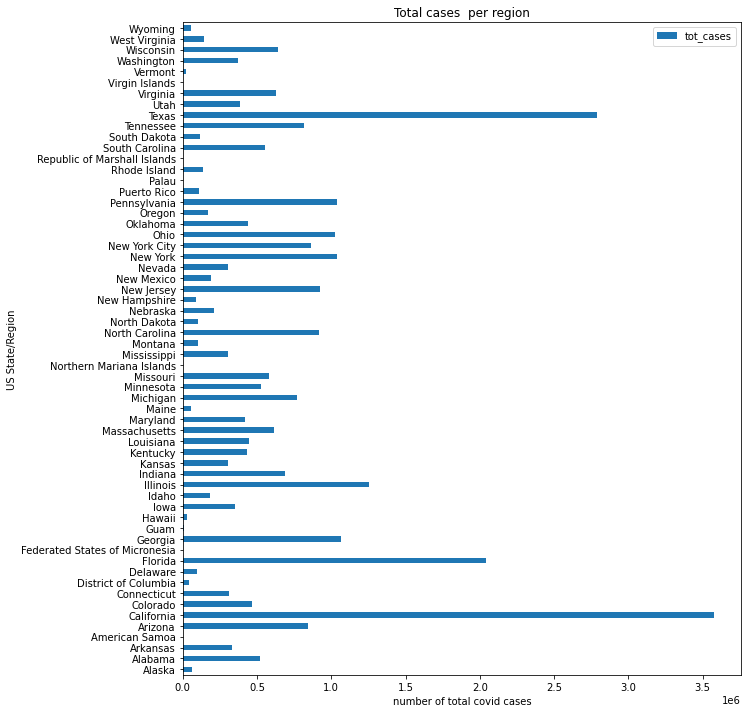

In [30]:
#Compare the total cases per state
raw_df_no_US.plot(x="name", y="tot_cases", kind="barh", figsize=(10, 12), title='Total cases  per region')
plt.xlabel('number of total covid cases')
plt.ylabel('US State/Region')

Text(0, 0.5, 'US State/Region')

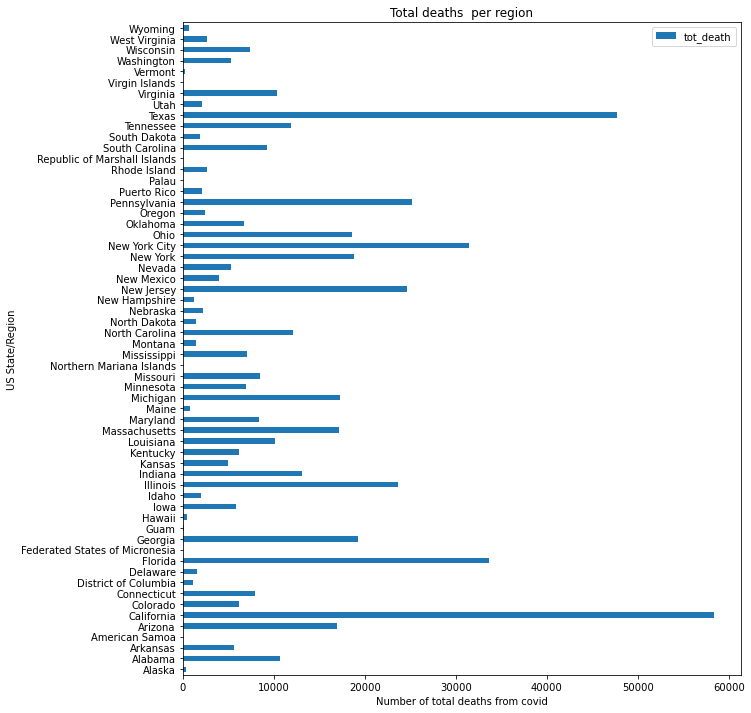

In [31]:
#Compare the total deaths per state
raw_df_no_US.plot(x="name", y="tot_death", kind="barh", figsize=(10, 12), title='Total deaths  per region')
plt.xlabel('Number of total deaths from covid')
plt.ylabel('US State/Region')

In [32]:
#Statistical summary
raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
tot_cases,61.0,999748.655738,3.891957e+06,0.0,103638.0,352874.0,689965.0,30492334.0
tot_cases_last_24_hours,61.0,1114.573770,8.705099e+03,0.0,0.0,0.0,0.0,67989.0
conf_cases,61.0,458653.344262,1.789832e+06,0.0,0.0,47786.0,437893.0,13988927.0
prob_cases,61.0,69811.377049,2.735836e+05,0.0,0.0,0.0,59882.0,2129247.0
new_cases07,61.0,14688.852459,5.728053e+04,0.0,1280.0,2824.0,9304.0,448010.0
new_deaths07,61.0,184.688525,7.259347e+02,0.0,12.0,41.0,108.0,5633.0
Seven_day_avg_new_cases_per_100k,61.0,17.265574,1.294921e+01,0.0,8.6,14.5,23.1,64.6
Seven_day_avg_new_deaths_per_100k,61.0,0.188525,1.403547e-01,0.0,0.1,0.2,0.2,0.7
Seven_day_cum_new_cases_per_100k,61.0,120.809836,9.069007e+01,0.0,60.3,101.4,161.6,452.5
Seven_day_cum_new_deaths_per_100k,61.0,1.293443,9.770481e-01,0.0,0.7,1.1,1.7,4.8


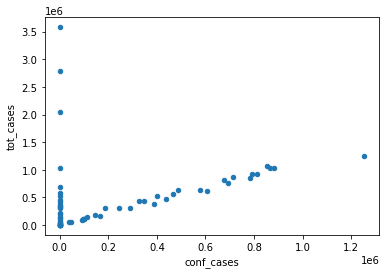

In [34]:
# 'confirmeraw_df_no_US.plot(x='conf_cases', y='tot_cases', kind='scatter');d cases' vs 'total cases'
raw_df_no_US.plot(x='conf_cases', y='tot_cases', kind='scatter');

In [35]:
Non_zero_raw_df_no_US = raw_df_no_US[raw_df_no_US['conf_cases'] != 0]

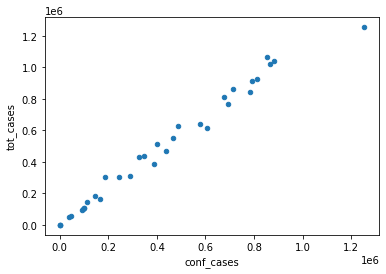

In [36]:
Non_zero_raw_df_no_US.plot(x='conf_cases', y='tot_cases', kind='scatter');

WE can drop the column 'conf_cases' since it appears the two quantitiess `total cases` and `confirmed cases` are statistically similar

In [37]:
raw_df_no_US.drop(columns='conf_cases', inplace=True)
raw_df.drop(columns='conf_cases', inplace=True)

In [39]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,56226,56254,56290,56294,56322,56384,56454,56517,56572,56595
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,122767,123216,123641,124134,124419,124723,125157,125506,125842,126183
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,116543,116657,116750,116836,116946,117061,117192,117304,117429,117524
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,11687,11732,11809,11850,11888,11944,12010,12053,12115,12174
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,21914,21961,22031,22063,22132,22182,22311,22399,22467,22579


In [40]:
# Missing values in each column and the percentage
missing_1 = pd.concat([confirmed_df.isnull().sum(), 100 * confirmed_df.isnull().mean()], axis=1)
missing_1.columns=['count', '%']
missing_1.sort_values(by=['count', '%'])

,count,%
Country/Region,0,0.000000
1/22/20,0,0.000000
1/23/20,0,0.000000
1/24/20,0,0.000000
1/25/20,0,0.000000
...,...,...
4/2/21,0,0.000000
4/3/21,0,0.000000
Lat,1,0.364964
Long,1,0.364964


In [55]:
confirmed_df.drop(columns=['Lat', 'Long'], inplace=True)
deaths_df.drop(columns=['Lat', 'Long'], inplace=True)
recoveries_df.drop(columns=['Lat', 'Long'], inplace=True)
us_data.drop(columns=['Lat', 'Long_'], inplace=True)

Since columns `Lat` and `Long` for latitude and longitude, will not be used in our EDA, we drop them

In [48]:
confirmed_df.head()

,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,56226,56254,56290,56294,56322,56384,56454,56517,56572,56595
1,NaN,Albania,0,0,0,0,0,0,0,0,...,122767,123216,123641,124134,124419,124723,125157,125506,125842,126183
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,116543,116657,116750,116836,116946,117061,117192,117304,117429,117524
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,11687,11732,11809,11850,11888,11944,12010,12053,12115,12174
4,NaN,Angola,0,0,0,0,0,0,0,0,...,21914,21961,22031,22063,22132,22182,22311,22399,22467,22579


## 1.3 Exploratory Data Analysis